# USAD

In [ ]:
'''
## 최초 1회 실행
!rm -r sample_data
'''

## Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

## EDA - Data Pre-Processing

### Down load datasets

In [ ]:
'''
## 최초 1회 실행
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/
'''

### Normal period

In [2]:
data_path = "C:\\Users\\PC0\\Documents\\GitHub\\datasets\\"

In [3]:
#Read data
normal = pd.read_csv(data_path + "SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

C:\Users\PC0\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(495000, 51)

In [4]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [5]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [6]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [7]:
#Read data
attack = pd.read_csv(data_path + "SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

C:\Users\PC0\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(449919, 51)

In [8]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [9]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [10]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

In [11]:
window_size=12

In [12]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [13]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [15]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 * .5 * windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 * .5 * windows_normal.shape[0])):int(np.floor(.5 * windows_normal.shape[0]))]
windows_normal_test = windows_normal[int(np.floor(.5 * windows_normal.shape[0])):]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(np.concatenate([windows_normal_test,windows_attack])).float().view(([windows_normal_test.shape[0]+windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [16]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0605, val_loss2: 0.0565
Epoch [1], val_loss1: 0.0395, val_loss2: -0.0006
Epoch [2], val_loss1: 0.0337, val_loss2: -0.0136
Epoch [3], val_loss1: 0.0357, val_loss2: -0.0200
Epoch [4], val_loss1: 0.0362, val_loss2: -0.0231
Epoch [5], val_loss1: 0.0356, val_loss2: -0.0249
Epoch [6], val_loss1: 0.0352, val_loss2: -0.0262
Epoch [7], val_loss1: 0.0321, val_loss2: -0.0250
Epoch [8], val_loss1: 0.0289, val_loss2: -0.0235
Epoch [9], val_loss1: 0.0166, val_loss2: -0.0133
Epoch [10], val_loss1: 0.0229, val_loss2: -0.0200
Epoch [11], val_loss1: 0.0222, val_loss2: -0.0198
Epoch [12], val_loss1: 0.0207, val_loss2: -0.0185
Epoch [13], val_loss1: 0.0176, val_loss2: -0.0158
Epoch [14], val_loss1: 0.0135, val_loss2: -0.0118
Epoch [15], val_loss1: 0.0218, val_loss2: -0.0199
Epoch [16], val_loss1: 0.0140, val_loss2: -0.0125
Epoch [17], val_loss1: 0.0159, val_loss2: -0.0143
Epoch [18], val_loss1: 0.0137, val_loss2: -0.0123
Epoch [19], val_loss1: 0.0134, val_loss2: -0.0121
Epoch [20],

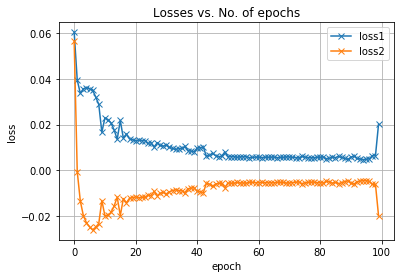

In [17]:
plot_history(history)

In [18]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [19]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [20]:
results=testing(model,test_loader)

In [21]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
y_test=np.concatenate([np.zeros(windows_normal_test.shape[0]),
                       np.ones(windows_attack.shape[0])])

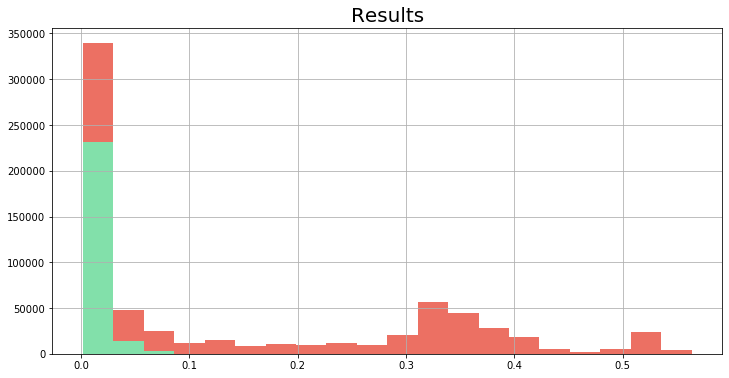

In [22]:
histogram(y_test,y_pred)

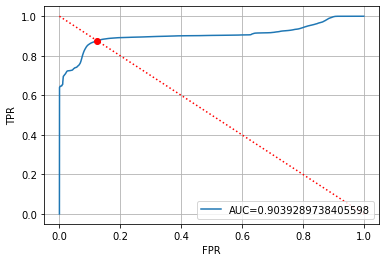

In [23]:
threshold=ROC(y_test,y_pred)

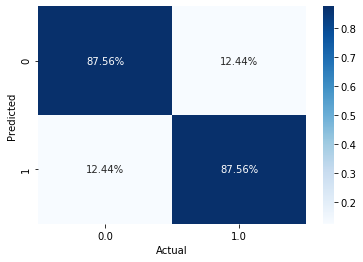

In [24]:
confusion_matrix(y_test,np.where(y_pred > threshold, 1, 0),perc=True)

## Anomaly gap maximize net

* 제안 아이디어 검증

In [14]:
class UsadModel_AGM(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)

    def training_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        real_recon1 = batch-w1
        real_recon2 = batch-w2
        fake_recon = batch-w3
        
        with torch.no_grad():
            pg_advantage = torch.mean((fake_recon)**2)-torch.mean((real_recon2)**2)
        
        loss1 = 1/n*torch.mean((real_recon1)**2)+(1-1/n)*torch.mean((fake_recon)**2) # AE1 - generator
        loss2 = 1/n*torch.mean((real_recon2)**2)-(1-1/n)*torch.mean((fake_recon)**2) # AE2 - discriminator
        loss3 = torch.mean(-torch.log(w3+1e-6) * pg_advantage)
        
        return loss1,loss2,loss3

    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        
        real_recon1 = batch-w1
        real_recon2 = batch-w2
        fake_recon = batch-w3
        
        pg_advantage = torch.mean((fake_recon)**2)-torch.mean((real_recon2)**2)
        
        loss1 = 1/n*torch.mean((real_recon1)**2)+(1-1/n)*torch.mean((fake_recon)**2) # AE1 - generator
        loss2 = 1/n*torch.mean((real_recon2)**2)-(1-1/n)*torch.mean((fake_recon)**2) # AE2 - discriminator
        loss3 = torch.mean(-torch.log(w3+1e-6) * pg_advantage)
        
        return {'val_loss1': loss1, 'val_loss2': loss2, 'val_loss3': loss3}

    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = torch.stack(batch_losses1).mean()
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = torch.stack(batch_losses2).mean()
        batch_losses3 = [x['val_loss3'] for x in outputs]
        epoch_loss3 = torch.stack(batch_losses3).mean()
        return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item(), 'val_loss3': epoch_loss3.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}, val_loss3: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2'], result['val_loss3']))
    
def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch=to_device(batch,device)
            loss1,loss2,loss3 = model.training_step(batch,epoch+1)
            
            loss1.backward(retain_graph=True)
            loss2.backward(retain_graph=True)
            loss3.backward()
            optimizer1.step()
            optimizer2.step()
            optimizer1.zero_grad()
            optimizer2.zero_grad()
        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    
def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [15]:
import torch.utils.data as data_utils

BATCH_SIZE = 7919
N_EPOCHS = 100
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 * .5 * windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 * .5 * windows_normal.shape[0])):int(np.floor(.5 * windows_normal.shape[0]))]
windows_normal_test = windows_normal[int(np.floor(.5 * windows_normal.shape[0])):]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(np.concatenate([windows_normal_test,windows_attack])).float().view(([windows_normal_test.shape[0]+windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel_AGM(w_size, z_size)
model = to_device(model,device)

In [16]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0535, val_loss3: 0.0020
Epoch [1], val_loss1: 0.0405, val_loss3: 0.0009
Epoch [2], val_loss1: 0.0344, val_loss3: 0.0022
Epoch [3], val_loss1: 0.0326, val_loss3: 0.0019
Epoch [4], val_loss1: 0.0322, val_loss3: 0.0031
Epoch [5], val_loss1: 0.0314, val_loss3: 0.0001
Epoch [6], val_loss1: 0.0307, val_loss3: 0.0012
Epoch [7], val_loss1: 0.0292, val_loss3: 0.0001
Epoch [8], val_loss1: 0.0187, val_loss3: -0.0037
Epoch [9], val_loss1: 0.0201, val_loss3: 0.0097
Epoch [10], val_loss1: 0.0243, val_loss3: -0.0006
Epoch [11], val_loss1: 0.0178, val_loss3: -0.0002
Epoch [12], val_loss1: 0.0171, val_loss3: -0.0022
Epoch [13], val_loss1: 0.0204, val_loss3: -0.0055
Epoch [14], val_loss1: 0.0183, val_loss3: -0.0563
Epoch [15], val_loss1: 0.0176, val_loss3: -0.0078
Epoch [16], val_loss1: 0.0161, val_loss3: -0.0067
Epoch [17], val_loss1: 0.0174, val_loss3: -0.0153
Epoch [18], val_loss1: 0.0173, val_loss3: -0.0193
Epoch [19], val_loss1: 0.0151, val_loss3: -0.0323
Epoch [20], val_los

In [58]:
def plot_history_2(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    losses3 = [x['val_loss3'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.plot(losses3, '-x', label="loss3")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

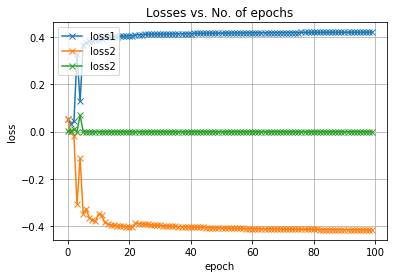

In [59]:
plot_history_2(history)

In [17]:
def plot_history_3(history):
    losses1 = [x['val_loss1'] for x in history]
    #losses2 = [x['val_loss2'] for x in history]
    losses3 = [x['val_loss3'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    #plt.plot(losses2, '-x', label="loss2")
    plt.plot(losses3, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

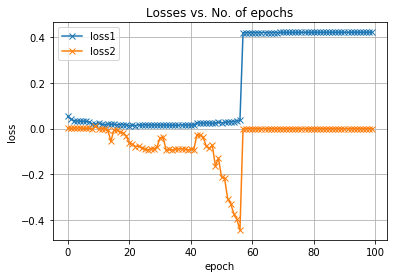

In [18]:
plot_history_3(history)

In [60]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model_agm.pth")

## Testing

In [61]:
checkpoint = torch.load("model_agm.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [19]:
results=testing(model,test_loader)

In [20]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
y_test=np.concatenate([np.zeros(windows_normal_test.shape[0]),
                       np.ones(windows_attack.shape[0])])

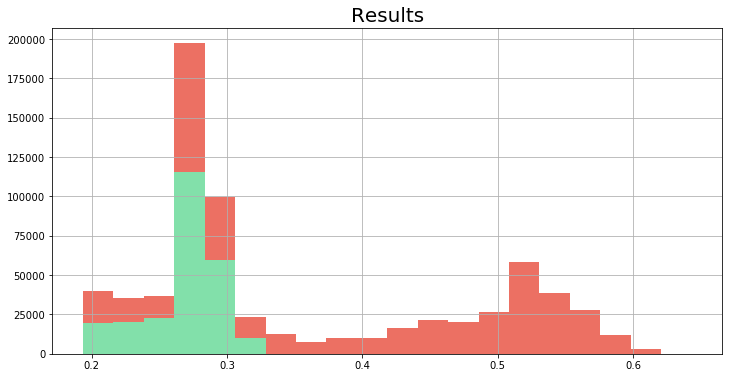

In [21]:
histogram(y_test,y_pred)

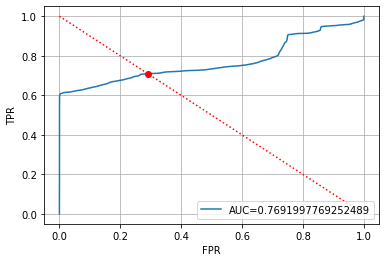

In [22]:
threshold=ROC(y_test,y_pred)

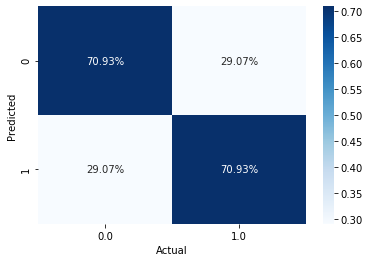

In [23]:
confusion_matrix(y_test,np.where(y_pred > threshold, 1, 0),perc=True)

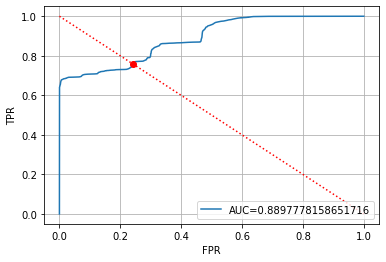

In [65]:
threshold=ROC(y_test,y_pred)

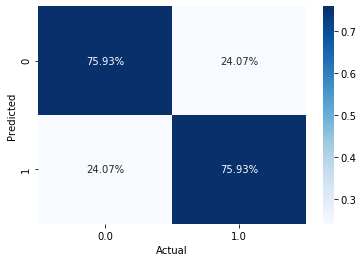

In [66]:
confusion_matrix(y_test,np.where(y_pred > threshold, 1, 0),perc=True)